# Predicting Movie Performance

I have compiled data for all the movies from 2011-2016 that had an opening US weekend box office total of $10m or more. We have some limited data points for each movie including genre, creative source, and production budget. Given the data for films from 2011-2015, can we predict the results of movies in 2016?

We'll be using a variety of decision tree techniques, including random forests and boosted trees.

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
import pydot
from sklearn import tree
import StringIO

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Data Preparation
Here we'll be using pandas (http://pandas.pydata.org/) to import our data sets and ready our data for analysis. I've made sure that the data is already pretty normalized to make things easy on us.

However, scikit-learn doesn't support categorical features in its decision trees. We'll need to convert all of our categorical columns to numerical columns using one-hot encoding.

In [4]:
train = pd.read_csv('train.csv',parse_dates=[0])
trainY = train['Infl. Adj. Dom. Box Office']
del train['Infl. Adj. Dom. Box Office']

test = pd.read_csv('test.csv',parse_dates=[0])
testY = test['Infl. Adj. Dom. Box Office']
del test['Infl. Adj. Dom. Box Office']

train.head()
#trainY.head()

,Released,Title,Theatrical Distributor,Genre,Source,Production Method,Creative Type,Production Budget,Theatrical Engagements
0,2013-04-12,42,Warner Bros.,Drama,Based on Real Life Events,Live Action,Dramatization,40000000,21418
1,2013-08-02,2 Guns,Universal,Action,Based on Comic/Graphic Novel,Live Action,Contemporary Fiction,61000000,15505
2,2012-03-16,21 Jump Street,Sony Pictures,Comedy,Based on TV,Live Action,Contemporary Fiction,42000000,22744
3,2014-06-13,22 Jump Street,Sony Pictures,Comedy,Based on TV,Live Action,Contemporary Fiction,50000000,22821
4,2014-02-21,3 Days to Kill,Relativity,Thriller/Suspense,Original Screenplay,Live Action,Contemporary Fiction,28000000,11265


In [5]:
def onehot(train=train,test=test,column='Theatrical Distributor'):
    le = LabelEncoder()
    s = train[column]
    s = s.append(test[column])
    le.fit(s)
    s1 = le.transform(train[column])
    s2 = le.transform(test[column])
    a = np.append(s1,s2).reshape(-1,1)
    oh = OneHotEncoder(sparse=False)
    oh.fit(a)
    train_out = oh.transform(s1.reshape(-1,1))
    test_out = oh.transform(s2.reshape(-1,1))
    train_df = pd.DataFrame(train_out).rename(columns=lambda x: le.inverse_transform(x))
    test_df = pd.DataFrame(test_out).rename(columns=lambda x: le.inverse_transform(x))
    return (train_df, test_df)

In [6]:
trainX = pd.DataFrame()
trainX['budget'] = train['Production Budget']
trainX['theaters'] = train['Theatrical Engagements']

testX = pd.DataFrame()
testX['budget'] = test['Production Budget']
testX['theaters'] = test['Theatrical Engagements']
categorical_features = ['Theatrical Distributor', 'Genre', 'Source', 'Production Method', 'Creative Type']
for c in categorical_features:
    (t1,t2) = onehot(column=c)
    trainX = trainX.join(t1)
    testX = testX.join(t2)
trainX.head()

,budget,theaters,20th Century Fox,CBS Films,FilmDistrict,Focus / Gramercy,Focus Features,Lionsgate,Open Road,Paramount Pictures,...,Stop-Motion Animation,Contemporary Fiction,Dramatization,Factual,Fantasy,Historical Fiction,Kids Fiction,Multiple Creative Types,Science Fiction,Super Hero
0,40000000,21418,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,61000000,15505,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,42000000,22744,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,50000000,22821,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,28000000,11265,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Building Our First Decision Tree

In [7]:
regressor = DecisionTreeRegressor()
regressor.fit(trainX,trainY)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [8]:
dotfile = StringIO.StringIO()
tree.export_graphviz(regressor, out_file=dotfile)
(graph,) = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("tree.png")

True

![Tree](tree.png)

In [9]:
train.iloc[25]

Released                           2015-07-17 00:00:00
Title                                          Ant-Man
Theatrical Distributor                     Walt Disney
Genre                                           Action
Source                    Based on Comic/Graphic Novel
Production Method                          Live Action
Creative Type                               Super Hero
Production Budget                            130000000
Theatrical Engagements                           25916
Name: 25, dtype: object

In [29]:
print regressor.decision_path(trainX.iloc[25])
print trainX.columns[regressor.tree_.feature[626]]
print trainX[trainX.columns[regressor.tree_.feature[626]]].iloc[25]
print regressor.tree_.threshold[626]
print "${:,}".format(regressor.predict(trainX.iloc[25])[0])

  (0, 0)	1
  (0, 626)	1
  (0, 627)	1
  (0, 628)	1
  (0, 629)	1
  (0, 713)	1
  (0, 714)	1
  (0, 730)	1
  (0, 731)	1
  (0, 732)	1
  (0, 734)	1
  (0, 735)	1
  (0, 736)	1
theaters
25916
35699.0
$184,904,943.0


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [30]:
regressor.score(trainX,trainY)

1.0

In [31]:
regressor.score(testX,testY)

0.72551109823770032

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

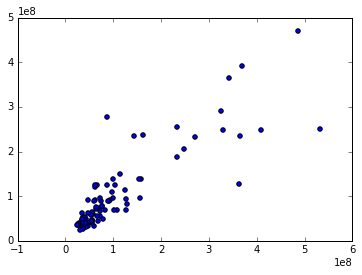

In [36]:
plt.scatter(testY,regressor.predict(testX))